# Update Log

v14 : Added some new features , now local CV has climed to 0.87 just with Meta-Features and can climb even more , this is the first notebook exploring high end score with just the metafeatures.

I have also removed the embedding layer because the model performs better without it

v15 : Inference added

# About this competition

Hello everyone , In this competition , we are asked to classify whether a person has beningn or a melignant melanoma based on the images of skin lesions taken from various parts of the body over different period of times . We have been also given some metadata information to improve results. Given this let's see what we know so far

# What we know so far?

We know the data is highly imbalanced with almost 98 percent of images being beningn .The discussion forum is filled with threads expressing kernels about the mystery images (image clusters that are present in test set but not in train set). This notebook does not include any EDA and discussions regarding what has already been discovered and explained thoroughly but for all those who are just getting started with this competition , I am adding all the necessary and important kernels and discussions to get up to speed quickly :-

* [EDA kernel by Andrada](https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations)
* [Exceptional Kernel giving all the insights about this competition by Laura](https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up)
* [Code used to merge external Data and Data Splitting by Alex](https://www.kaggle.com/shonenkov/merge-external-data)
* [Best Public TensorFlow Pipeline with explanantion of best CV strategy by chris deotte](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)
* [Mystery Images Discussion Thread by Chris Deotte](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/168028)

Now that you know what the competition is about the underlying difficulties and solutions which people have adapted so far let's understand what this notebook is all about

# About this Notebook

We have been given two types of data , one is the images of skin lesions of patients , other is the tabular meta data . Now there are three ways of combining these two information together :-

* Build a CNN image model and find a way to input the tabular data into the CNN image model
* Build a Tabular data model and find a way to extract image embeddings or image features and input into the Tabular data model
* Build 2 separate models for images and metadata and ensemble

**We have tried all three and the third option works the best and gives significant amount of boost. Now another question comes to find what models can we use for modelling with tabular data , this notebook tries to answer this question only**

<font color='orange'>What if I say you can use a neural network architecture based on attention and transformers especially designed for tabular data,that too with your own custom loss, custom lr and all the techniques that you might be applying with your image model , one such architecture which can give very could results IMO is Google's Tabnet. </font>

People have already applied Tabnet for this competition using Pytorch-Tabnet implementation by Sebastien ([@optimo](https://www.kaggle.com/optimo)) . The Implementation can be found [here](https://github.com/dreamquark-ai/tabnet). However this implementations comes with following limitations : 
* We cannot use custom losses, custom LR schedulers
* We cannot use custom samplers which we found to have improved results considerably
* We are provided with a scikit-learn type interface which makes it really easy to use tabnet but at the same time takes away the benifits of it being a deep learning model

**This Notebook also tries to address and solve these limitations**

# How this  Notebook solves the Limitations

Here in this notebook I show how to use Tabnet as a custom Model instead of the scikit-learn type interface provided by Pytorch-Tabnet , thanks to Sebastien and his active responses on the github repo . I show how anyone can use Tabnet just like a torchvision or any torch-hub model for any downstream task . I have tried to write a code in such a way that anyone can use this code and apply it to their tasks by just changing the dataset and dataloader. Here are the components that any deep learning models need :-
* Dataset + DataLoader
* Model
* Criterion/Loss
* Training Loop
* Evaluation Loop
* Engine for uniting all of them together

# Things used Specific to this competition

* For Data I am using the dataset and folds provided by [@alex](https://www.kaggle.com/shonenkov) [here](https://www.kaggle.com/shonenkov/melanoma-merged-external-data-512x512-jpeg) which has been generated using the notebook [here](https://www.kaggle.com/shonenkov/merge-external-data)
* Embeddings for Categorical Variables
* Soft Margin Focal Loss , because it has seemed to work the best as of now , you can play around with that 
* Balance Sampler for balancing classes in each batch
* A Plotting fucntion adapted from chris Deotte's Training kernel
* ReduceOn Pleateau Lr Scheduler 

**I hope you all like my efforts and find this kernel useful** 

<font color='red'> Before diving into code , if you want to understand how tabnet works , you can watch the following talk given
by Sebastien

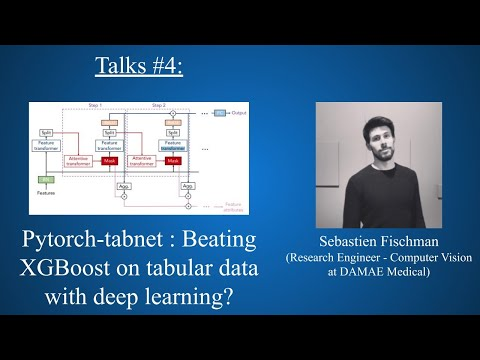

In [1]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('ysBaZO8YmX8',width=600, height=400)

If you want to do it the scikit learn way here is a [notebook](https://www.kaggle.com/tanulsingh077/achieving-sota-results-with-tabnet) where I explain how to that

In [2]:
#Installing Pytorch-Tabnet
!pip install pytorch-tabnet

ERROR: Could not find a version that satisfies the requirement pytorch-tabnet (from versions: none)
ERROR: No matching distribution found for pytorch-tabnet


In [3]:
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
from tqdm.autonotebook import tqdm
from fastprogress import master_bar, progress_bar
tqdm.pandas()
from scipy.stats import skew 
import pickle
import glob

#Visuals
import matplotlib.pyplot as plt

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from catalyst.data.sampler import BalanceClassSampler

#CV2
import cv2

#Importing Tabnet
from pytorch_tabnet.tab_network import TabNet

#error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Utils

Since we are writing our custom model , we need early stopping which is present in Pytorch-Tabnet's implementation as a built-in.
The following Early-Stopping Implementation can monitor both minimization and maximization of quantities

In [4]:
class EarlyStopping:
    def __init__(self, patience=7, mode="min", delta=0.001,verbose=False):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.verbose = verbose
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
                
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            if self.verbose:
                print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

# Configuration

We define all the configuration needed elsewhere in the notebook here

In [5]:
BATCH_SIZE = 1024 
EPOCHS = 150
LR = 0.02
seed = 2020   # seed for reproducible results
patience = 30
device = torch.device('cuda')
FOLDS = 5

# Seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True    

In [7]:
seed_everything(seed)

# Data Preparation and Feature Engineering

Here we input the data and prepare it for inputting to the model

In [8]:
# Defining Categorical variables and their Indexes, embedding dimensions , number of classes each have
df =pd.read_csv('/data/folds_13062020.csv')

In [9]:
df.head()

,image_id,patient_id,target,source,sex,age_approx,anatom_site_general_challenge,stratify_group,fold
0,ISIC_2637011,IP_7279968,0,ISIC20,male,45.0,head/neck,31,0
1,ISIC_0015719,IP_3075186,0,ISIC20,female,45.0,upper extremity,7,2
2,ISIC_0052212,IP_2842074,0,ISIC20,female,50.0,lower extremity,5,4
3,ISIC_0068279,IP_6890425,0,ISIC20,female,45.0,head/neck,7,0
4,ISIC_0074268,IP_8723313,0,ISIC20,female,55.0,upper extremity,6,4


In [10]:
# df = pd.concat([df, pd.get_dummies(df.source)], axis=1)

# df = pd.concat([df, pd.get_dummies(df.anatom_site_general_challenge)], axis=1)

# df.head()

# df['age_approx'] = (df.age_approx - df.age_approx.min()) / df.age_approx.max()

# df.head()

# df = pd.concat([df, pd.get_dummies(df.sex)], axis=1)

# df.drop('unknown', axis=1, inplace=True)

# df.head()

# features = df.iloc[:, -11:].columns.tolist() + ['age_approx']

In [11]:
df.drop(['image_id','stratify_group'],axis=1,inplace=True)
target = 'target'
unused_feat = ['patient_id','fold']
features = [ col for col in df.columns if col not in unused_feat+[target]] 

categorical_columns = []

for col in df.columns[df.dtypes == object]:
    
    if col not in unused_feat:
        print(col, df[col].nunique())
        
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        
        #SAVING LABEL _ ENC
        output = open(f'{col}_encoder.pkl', 'wb')
        pickle.dump(l_enc, output)
        output.close()
        
        categorical_columns.append(col)

source 2
sex 3
anatom_site_general_challenge 8


In [12]:
class MelanomaDataset(Dataset):
    def __init__(self,features,target):
        self.features = features
        self.target = target
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        return{
            'features': torch.tensor(self.features[idx],dtype=torch.float),
             'target': self.one_hot(2, self.target[idx])
        }
    
    def get_targets(self):
        return list(self.target)
    
    @staticmethod
    def one_hot(size, target):
        tensor = torch.zeros(size, dtype=torch.float32)
        tensor[target] = 1.
        return tensor

# Model

Here we built our Custom Tabnet model

In [13]:
class CustomTabnet(nn.Module):
    def __init__(self, input_dim, output_dim,n_d=8, n_a=8,n_steps=3, gamma=1.3,
                cat_idxs=[], cat_dims=[], cat_emb_dim=1,n_independent=2, n_shared=2,
                momentum=0.02,mask_type="sparsemax"):
        
        super(CustomTabnet, self).__init__()
        self.tabnet = TabNet(input_dim=input_dim,output_dim=output_dim, n_d=n_d, n_a=n_a,n_steps=n_steps, gamma=gamma,
                             cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=cat_emb_dim,n_independent=n_independent,
                             n_shared=n_shared, momentum=momentum,mask_type="sparsemax")
        
        
    def forward(self, x):
        return self.tabnet(x)

# Loss

Defining SoftMarginFocal Loss which is to be used as a criterion

In [14]:
class SoftMarginFocalLoss(nn.Module):
    def __init__(self, margin=0.2, gamma=2):
        super(SoftMarginFocalLoss, self).__init__()
        self.gamma = gamma
        self.margin = margin
                
        self.weight_pos = 2
        self.weight_neg = 1
    
    def forward(self, inputs, targets):
        em = np.exp(self.margin)
        
        log_pos = -F.logsigmoid(inputs)
        log_neg = -F.logsigmoid(-inputs)
        
        log_prob = targets*log_pos + (1-targets)*log_neg
        prob = torch.exp(-log_prob)
        margin = torch.log(em + (1-em)*prob)
        
        weight = targets*self.weight_pos + (1-targets)*self.weight_neg
        loss = self.margin + weight * (1 - prob) ** self.gamma * log_prob
        
        loss = loss.mean()
        
        return loss

# Training

Our Custom Training loop

In [15]:
def train_fn(dataloader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    
    train_targets=[]
    train_outputs=[]
    
    for bi,d in enumerate(dataloader):
        features = d['features']
        target = d['target']
        
        features = features.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        
        output,_ = model(features)
        
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
        output  = 1 - F.softmax(output,dim=-1).cpu().detach().numpy()[:,0]  
        
        train_targets.extend(target.cpu().detach().numpy().argmax(axis=1).astype(int).tolist())
        train_outputs.extend(output)
            
        
    return loss.item(),train_outputs,train_targets

# Evaluation

Custom Evaluation loop

In [16]:
def eval_fn(data_loader,model,criterion,device):
    
    fin_targets=[]
    fin_outputs=[]
    
    model.eval()
    with torch.no_grad():
        
        for bi, d in enumerate(data_loader):
            features = d["features"]
            target = d["target"]

            features = features.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            outputs,_ = model(features)            
            loss_eval = criterion(outputs,target)            
            outputs  = 1 - F.softmax(outputs,dim=-1).cpu().detach().numpy()[:,0]              
            fin_targets.extend(target.cpu().detach().numpy().argmax(axis=1).astype(int).tolist())
            fin_outputs.extend(outputs)
            
    return loss_eval.item(),fin_outputs,fin_targets

# Plotter

Function for plotting the losses and auc_scores for each fold 

In [17]:
def print_history(fold,history,num_epochs=EPOCHS):
        plt.figure(figsize=(15,5))
        
        plt.plot(
            np.arange(num_epochs),
            history['train_history_auc'],
            '-o',
            label='Train AUC',
            color='#ff7f0e'
        )
        
        plt.plot(
            np.arange(num_epochs),
            history['val_history_auc'],
            '-o',
            label='Val AUC',
            color='#1f77b4'
        )
        
        x = np.argmax(history['val_history_auc'])
        y = np.max(history['val_history_auc'])
        
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        
        plt.scatter(x, y, s=200, color='#1f77b4')
        
        plt.text(
            x-0.03*xdist,
            y-0.13*ydist,
            'max auc\n%.2f'%y,
            size=14
        )
        
        plt.ylabel('AUC', size=14)
        plt.xlabel('Epoch', size=14)
        
        plt.legend(loc=2)
        
        plt2 = plt.gca().twinx()
        
        plt2.plot(
            np.arange(num_epochs),
            history['train_history_loss'],
            '-o',
            label='Train Loss',
            color='#2ca02c'
        )
        
        plt2.plot(
            np.arange(num_epochs),
            history['val_history_loss'],
            '-o',
            label='Val Loss',
            color='#d62728'
        )
        
        x = np.argmin(history['val_history_loss'])
        y = np.min(history['val_history_loss'])
        
        ydist = plt.ylim()[1] - plt.ylim()[0]
        
        plt.scatter(x, y, s=200, color='#d62728')
        
        plt.text(
            x-0.03*xdist, 
            y+0.05*ydist, 
            'min loss', 
            size=14
        )
        
        plt.ylabel('Loss', size=14)
        
        plt.title(f'FOLD {fold + 1}',size=18)
        
        plt.legend(loc=3)
        plt.show()  

# Engine

Engine where we unite everything

In [18]:
def run(fold):
    
    df_train = df[df.fold != fold]
    df_valid = df[df.fold == fold]
    
    # Defining DataSet
    train_dataset = MelanomaDataset(
        df_train[features].values,
        df_train[target].values
    )
  
    
    valid_dataset = MelanomaDataset(
        df_valid[features].values,
        df_valid[target].values
    )
    
    # Defining DataLoader with BalanceClass Sampler
    train_loader = DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(
            labels=train_dataset.get_targets(), 
            mode="downsampling",
        ),
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=True,
        num_workers=4
    )
    
    
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
    )
    
    # Defining Device
    device = torch.device("cuda")
    
    # Defining Model for specific fold
    model = CustomTabnet(input_dim = len(features), 
                         output_dim = 2,
                         n_d=32, 
                         n_a=32,
                         n_steps=4, 
                         gamma=1.6,
                         n_independent=2,
                         n_shared=2,
                         momentum=0.02,
                         mask_type="sparsemax")
    
    model.to(device)
    
    #DEfining criterion
    criterion = SoftMarginFocalLoss()
    criterion.to(device)
        
    # Defining Optimizer with weight decay to params other than bias and layer norms
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
            ]  
    
    optimizer = torch.optim.AdamW(optimizer_parameters, lr=LR)
    
    # Defining LR SCheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                           factor=0.5, patience=5, verbose=True, 
                                                           threshold=0.0001, threshold_mode='rel',
                                                           cooldown=0, min_lr=0, eps=1e-08)
    #DEfining Early Stopping Object
    es = EarlyStopping(patience=patience,verbose=False)
    
    # History dictionary to store everything
    history = {
            'train_history_loss': [],
            'train_history_auc': [],
            'val_history_loss': [],
            'val_history_auc': [],
        }
        
    # THE ENGINE LOOP    
    mb = progress_bar(range(EPOCHS), total=EPOCHS)
    for epoch in mb:
        train_loss,train_out,train_targets = train_fn(train_loader, model,criterion, optimizer, device,scheduler=None,epoch=epoch)
        
        val_loss,outputs, targets = eval_fn(valid_loader, model, criterion,device)
        
        train_auc = roc_auc_score(train_targets, train_out)
        auc_score = roc_auc_score(targets, outputs)
        
        scheduler.step(auc_score)
        
        #mb.set_postfix(Train_Loss=train_loss,Train_AUC_SCORE = train_auc,Valid_Loss = val_loss,Valid_AUC_SCORE = auc_score)
        mb.comment = f'train Loss: {train_loss:.4f}, valid_loss: {val_loss:.4f}, auc_score: {auc_score:.4f}'
        history['train_history_loss'].append(train_loss)
        history['train_history_auc'].append(train_auc)
        history['val_history_loss'].append(val_loss)
        history['val_history_auc'].append(auc_score)

        es(val_loss,model,f'model_{fold}.bin')
        
        if es.early_stop:
            print('Maximum Patience {} Reached , Early Stopping'.format(patience))
            break   
            
    print_history(fold,history,num_epochs=epoch+1)

Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch     7: reducing learning rate of group 1 to 1.0000e-02.
Epoch    13: reducing learning rate of group 0 to 5.0000e-03.
Epoch    13: reducing learning rate of group 1 to 5.0000e-03.
Epoch    19: reducing learning rate of group 0 to 2.5000e-03.
Epoch    19: reducing learning rate of group 1 to 2.5000e-03.
Epoch    56: reducing learning rate of group 0 to 1.2500e-03.
Epoch    56: reducing learning rate of group 1 to 1.2500e-03.
Epoch    62: reducing learning rate of group 0 to 6.2500e-04.
Epoch    62: reducing learning rate of group 1 to 6.2500e-04.
Epoch    68: reducing learning rate of group 0 to 3.1250e-04.
Epoch    68: reducing learning rate of group 1 to 3.1250e-04.
Epoch    74: reducing learning rate of group 0 to 1.5625e-04.
Epoch    74: reducing learning rate of group 1 to 1.5625e-04.
Maximum Patience 30 Reached , Early Stopping


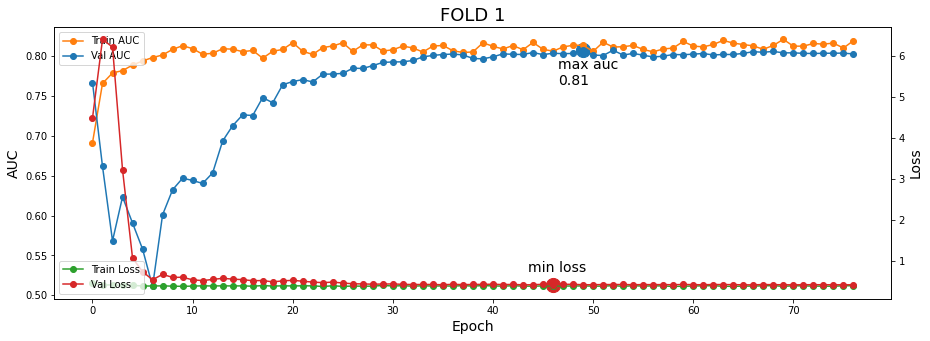

In [19]:
run(fold=0)

In [20]:
features

['source', 'sex', 'age_approx', 'anatom_site_general_challenge']

Epoch    21: reducing learning rate of group 0 to 1.0000e-02.
Epoch    21: reducing learning rate of group 1 to 1.0000e-02.
Epoch    57: reducing learning rate of group 0 to 5.0000e-03.
Epoch    57: reducing learning rate of group 1 to 5.0000e-03.
Epoch    69: reducing learning rate of group 0 to 2.5000e-03.
Epoch    69: reducing learning rate of group 1 to 2.5000e-03.
Epoch    75: reducing learning rate of group 0 to 1.2500e-03.
Epoch    75: reducing learning rate of group 1 to 1.2500e-03.
Maximum Patience 30 Reached , Early Stopping


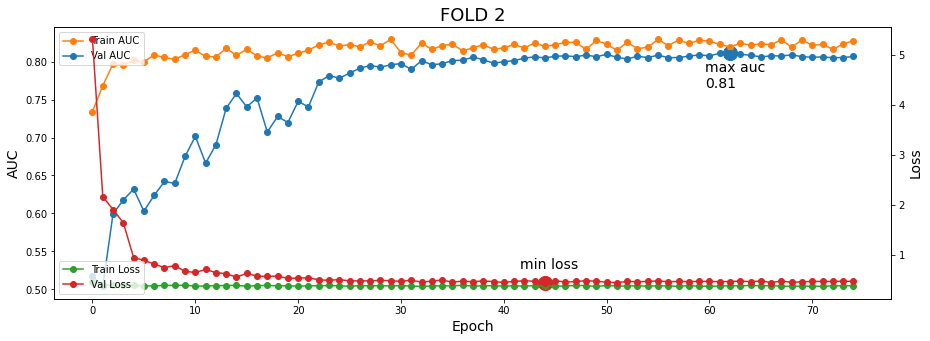

In [21]:
run(fold=1)

Epoch    54: reducing learning rate of group 0 to 1.0000e-02.
Epoch    54: reducing learning rate of group 1 to 1.0000e-02.
Maximum Patience 30 Reached , Early Stopping


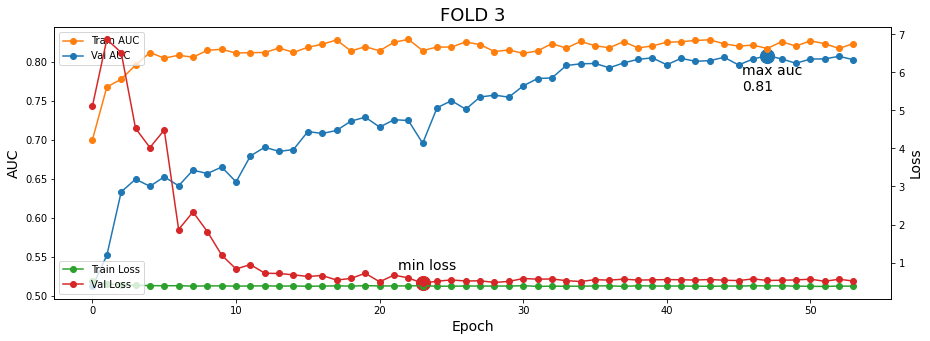

In [22]:
run(fold=2)

Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Epoch    19: reducing learning rate of group 1 to 1.0000e-02.
Epoch    33: reducing learning rate of group 0 to 5.0000e-03.
Epoch    33: reducing learning rate of group 1 to 5.0000e-03.
Epoch    51: reducing learning rate of group 0 to 2.5000e-03.
Epoch    51: reducing learning rate of group 1 to 2.5000e-03.
Epoch    57: reducing learning rate of group 0 to 1.2500e-03.
Epoch    57: reducing learning rate of group 1 to 1.2500e-03.
Epoch    66: reducing learning rate of group 0 to 6.2500e-04.
Epoch    66: reducing learning rate of group 1 to 6.2500e-04.
Maximum Patience 30 Reached , Early Stopping


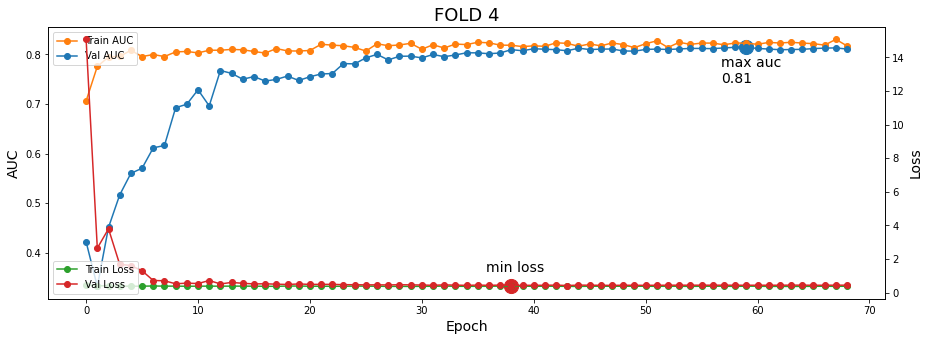

In [23]:
run(fold=3)

Epoch     8: reducing learning rate of group 0 to 1.0000e-02.
Epoch     8: reducing learning rate of group 1 to 1.0000e-02.
Epoch    44: reducing learning rate of group 0 to 5.0000e-03.
Epoch    44: reducing learning rate of group 1 to 5.0000e-03.
Maximum Patience 30 Reached , Early Stopping


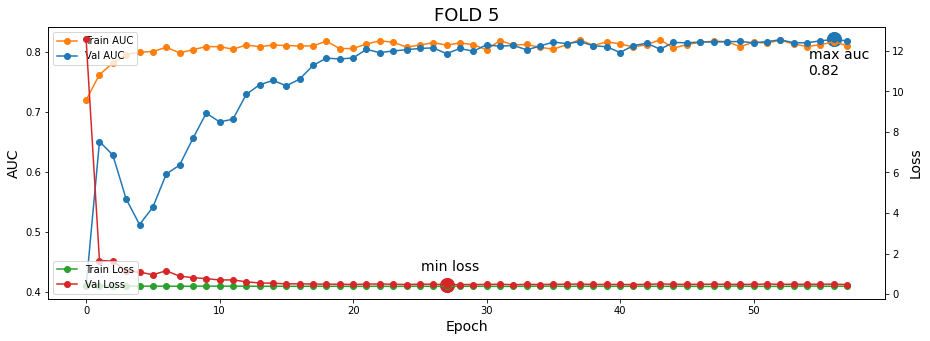

In [24]:
run(fold=4)

# Inference

In [33]:
df_test =pd.read_csv('/data/test.csv')
df_test['anatom_site_general_challenge'].fillna('unknown',inplace=True)
df_test['target'] = 0
df_test['source'] = 'ISIC20'

In [26]:
# df_test.head()

# df_test['age_approx'] = (df_test.age_approx - df_test.age_approx.min()) / df_test.age_approx.max()
# df_test = pd.concat([df_test, pd.get_dummies(df_test.sex), pd.get_dummies(df_test.anatom_site_general_challenge)], axis=1)

# df_test['ISIC19'] = 0
# df_test['ISIC20'] = 1

# df_test['target'] = 0

# df_test['lateral torso'] = 0

In [34]:
# Defining Categorical variables and their Indexes, embedding dimensions , number of classes each have 
df_test.drop(['image_name'],axis=1,inplace=True)
target = 'target'
unused_feat = ['patient_id','fold']
features = [ col for col in df_test.columns if col not in unused_feat+[target]] 

for col in df_test.columns[df_test.dtypes == object]:
    if col not in unused_feat:
        print(col, df_test[col].nunique())
        pkl_file = open(f'{col}_encoder.pkl', 'rb')
        l_enc = pickle.load(pkl_file) 
        df_test[col] = l_enc.transform(df_test[col].values)
        pkl_file.close()

sex 2
anatom_site_general_challenge 7
source 1


In [35]:
def load_model():
    
    models = []
    paths = glob.glob('model*')
    
    for path in tqdm(paths,total=len(paths)):
                
        model = CustomTabnet(input_dim = len(features), 
                         output_dim = 2,
                         n_d=32, 
                         n_a=32,
                         n_steps=4, 
                         gamma=1.6,
                         n_independent=2,
                         n_shared=2,
                         momentum=0.02,
                         mask_type="sparsemax")
        
        model.to(device)
        loader = torch.load(path)
        model.load_state_dict(loader)
        
        models.append(model)
        
    return models

In [36]:
models = load_model()

In [37]:
def make_prediction(data_loader):
    predictions = np.zeros((len(df_test),FOLDS))
    for i,model in enumerate(models):
        
        fin_outputs=[]
        
        model.eval()
        with torch.no_grad():
            
            for bi, d in enumerate(data_loader):
                features = d["features"]
                target = d["target"]

                features = features.to(device, dtype=torch.float)

                outputs,_ = model(features)

                outputs  = 1 - F.softmax(outputs,dim=-1).cpu().detach().numpy()[:,0]                
        
                fin_outputs.extend(outputs)
        
        predictions[:,i] = fin_outputs
    
    return predictions

In [38]:
test_dataset = MelanomaDataset(
        df_test[features].values,
        df_test[target].values
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=4,
        shuffle=False,
        pin_memory=True,
        drop_last=False,
    )

In [39]:
pred = make_prediction(test_loader)

# Writing Submission File

In [40]:
pred = pred.mean(axis=-1)
pred

array([0.67191767, 0.61105237, 0.96614472, ..., 0.80209954, 0.66739322,
       0.79263046])

In [41]:
ss = pd.read_csv('/data/sample_submission.csv')

In [42]:
ss['target'] = pred

In [43]:
ss.to_csv('submission.csv',index=False)
ss.head()

,image_name,target
0,ISIC_0052060,0.671918
1,ISIC_0052349,0.611052
2,ISIC_0058510,0.966145
3,ISIC_0073313,0.950249
4,ISIC_0073502,0.911956


In [44]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Tabnet One Hot"

100% 342k/342k [00:01<00:00, 247kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

# Thank you all for reading my Notebook